**IMPORT STATEMENTS**

In [ ]:
import pandas as pd
import gc
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers
import matplotlib.pylab as plt

**DATA LOADING**

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

## Change working directory
import os
os.chdir('/content/drive/MyDrive/AI/AI_Project')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1O7c9Hu69875akjm2oFZ4b7wCRKxBky1B/AI_Project


**DATA PREPROCESSING**


In [ ]:
Dataset = pd.read_csv('TweetsCOV19_052020.tsv', sep='\t', error_bad_lines=False)

Dataset.columns = ["tweet_id","username","timestamp","#followers","#retweets","#friends","#favorites","entities","sentiment","mentions","hashtags","urls"]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Import stop words and convert it into a set(no duplicates) for later use
# Stop words taken from nltk corpus 
stopWordsFile = open("./stop_words.txt")
stopWords = stopWordsFile.readlines()
stopWordsList=[]
for k in stopWords:
    stopWordsList+=k.split()
stopWordsSet = set(stopWordsList)

In [ ]:
# Import keywords and convert it into a set(no duplicates) for later use
covidKeywordsFile = open("./covid_keywords.txt")
covidKeywords = covidKeywordsFile.readlines()
covidKeywordsList=[]
for k in covidKeywords:
    covidKeywordsList+=k.split()
covidKeywordsSet = set(covidKeywordsList)

In [ ]:
# Split dataset into train and validation splits

trainDataset = Dataset.sample(frac=0.9, random_state=0)
testDataset = Dataset.drop(trainDataset.index)

print(Dataset.shape[0])
print(trainDataset.shape[0])
print(testDataset.shape[0])
print(trainDataset.shape[0] + testDataset.shape[0])

1912069
1720862
191207
1912069


**HELPER FUNCTIONS**

In [ ]:
# Helper Functions
def createDict(unique_val, start):
  count=start
  dic ={}
  for k in unique_val:
      dic[k]=count
      count+=1
  return dic

In [ ]:
def preprocessData(Dataset, covidKeywords, stopWords, isTrainData, usernameDict, standardizeDict):
  #===========================================================================================================================
  # Preprocessing username
  if isTrainData:
    # If is train dataset, create the dictionary for later use
    # Filtering out people that have <tweets_threshold number of tweets
    tweetsThreshold = 10 
    userCounts = Dataset["username"].value_counts()
    userCounts = userCounts[userCounts>=tweetsThreshold] 

    # Creating dictionary of username mapping for later use in validation set
    usernameDict["username"] = createDict(userCounts.index, 1) 
    Dataset["username"] = Dataset["username"].map(usernameDict["username"])
    Dataset["username"] = Dataset["username"].fillna(0)

  else: 
    # If is not train dataset(i.e. is Validation or test set), use previously made username dictionary to map usernames
    # Mapping username column to username dictionary previously created when preprocessing trainDataset
    Dataset["username"] = Dataset["username"].map(usernameDict)
    Dataset["username"] = Dataset["username"].fillna(0)

  #===========================================================================================================================
  # Preprocessing hashtags
  def keyword_hashtags(x,key_covid):
    if x=="null;":
        return 0
    else:
      # print(x)
      s = str(x).split(" ")
      ff=[]
      for z in s:
          ff.append(z.lower())
      count=0
      for zz in ff:
          if zz in key_covid:
              count+=1
      return count
        
  Dataset["keyword_hashtags"] = Dataset["hashtags"].apply(lambda x: keyword_hashtags(x, covidKeywords))

  #===========================================================================================================================
  # Preprocessing entities
  def keyword_entities(x,key_covid):
    if x=="null;":
        return 0
    else:
      # print(x)
      s = str(x).split(";")
      ff=[]
      for z in s[:-1]:
          temp = z.split(":")
          ff.append(temp[0].lower())
          ff.append(temp[1].lower())
      count=0
      for zz in ff:
          if zz in key_covid:
              count+=1
      return count

  Dataset["keyword_entities"] = Dataset["entities"].apply(lambda x: keyword_entities(x, covidKeywords))

  #===========================================================================================================================
  # Preprocessing counts
  def count(x,sep):
    if x!="null;" and str(x)!="nan":
        cc = x.split(sep)
        return len(cc)
    else:
        return 0
    
  def unique_hashtags(x):
      if x=="null;" or str(x)=="nan":
          return 0
      else:
          x=x.split(" ")
          return np.unique(x).size/len(x)
      
  def count_words(x):
      if x=="null;" or str(x)=="nan":
          return 0
      else:
          return len(x)

  Dataset["no_entities"] = Dataset["entities"].apply(lambda x: count(x,";"))
  Dataset["no_urls"] = Dataset["urls"].apply(lambda x: count(x,":-:"))
  Dataset["no_hashtags"] = Dataset["hashtags"].apply(lambda x: count(x," "))
  Dataset["no_mentions"] = Dataset["mentions"].apply(lambda x: count(x," "))
  Dataset["unique_hashtags"] = Dataset["hashtags"].apply(lambda x: unique_hashtags(x))
  Dataset["hashtags_char"] = Dataset["hashtags"].apply(lambda x: count_words(x))

  #===========================================================================================================================
  # Preprocessing timestamp
  def one_hot_week(x,dict_):
    len_=len(dict_)
    z=[0]*len_
    z[dict_[x]]=1
    return z
    
  def conv_dtime(v):
        v = v.split(":")
        return (float(v[0])*3600+float(v[1])*60+float(v[2]))/3600

  #===========================================================================================================================
  # Preprocessing ratio
  Dataset["follow/friends"]=Dataset["#followers"].astype(float)/(Dataset["#friends"].astype(float)+1)
  Dataset["friends/favorites"]=Dataset["#friends"].astype(float)/(Dataset["#favorites"].astype(float)+1)
  Dataset["favorites/follow"]=Dataset["#favorites"].astype(float)/(Dataset["#followers"].astype(float)+1)

  #===========================================================================================================================
  # Standardizing values = finding how many standard deviation away from mean
  featuresToStandardize=['#favorites', '#followers', '#friends', 'no_entities', 'no_hashtags', 
                        'no_mentions', 'no_urls',"follow/friends","friends/favorites","favorites/follow",
                      "unique_hashtags","hashtags_char","keyword_entities", "keyword_hashtags"]
  if isTrainData: 
    # If is train dataset, create the dictionary to save mean and standard deviation for later use in preprocessing validation set
    standardizeDict = {}
    for feature in featuresToStandardize:
      meanValue = Dataset[feature].mean()
      standardDeviationValue = Dataset[feature].std()
      Dataset[feature] = (Dataset[feature]-meanValue)/standardDeviationValue 
      standardizeDict[feature] = {"meanValue": meanValue, "standardDeviationValue": standardDeviationValue}
  else: 
    # If is not train dataset(i.e. is Validation or test set), use previously made mean and standard deviation dictionary from train dataset to standardize
    for feature in featuresToStandardize:
      Dataset[feature] = (Dataset[feature]-standardizeDict[feature]["meanValue"])/standardizeDict[feature]["standardDeviationValue"]

  #===========================================================================================================================
  # Returning relevant information
  if isTrainData: 
    # If is train dataset, return the preprocessed dataset, usernameDict and standardizeDict for use in validation and test dataset
    return Dataset, usernameDict, standardizeDict
  else: 
    # If is not train dataset(i.e. is Validation or test set), just return the preprocessed dataset
    return Dataset

In [ ]:
preprocessedTrainDataset, usernameDict, standardizeDict = preprocessData(trainDataset, covidKeywordsList, stopWords, isTrainData=True, usernameDict={}, standardizeDict={})
preprocessedTestDataset = preprocessData(testDataset, covidKeywordsList, stopWords, isTrainData=False, usernameDict=usernameDict, standardizeDict=standardizeDict)

In [ ]:
preprocessedTrainDataset = preprocessedTrainDataset.drop(columns=['timestamp','urls','sentiment','tweet_id','entities','mentions','hashtags'])
preprocessedTestDataset = preprocessedTestDataset.drop(columns=['timestamp','urls','sentiment','tweet_id','entities','mentions','hashtags'])

#### fix keyword_entities=NaN issue then include it in the dataset again

In [ ]:
#'day','week','time','timestamp','year','urls','date','sentiment','tweet_id','entities','mentions','hashtags','followers_null_ind','friends_null_ind','entity_null','hashtags_null','urls_null','mentions_null','sentiment_encoded'])

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
preprocessedTrainDataset.head(50)


,username,#followers,#retweets,#friends,#favorites,keyword_hashtags,keyword_entities,no_entities,no_urls,no_hashtags,no_mentions,unique_hashtags,hashtags_char,follow/friends,friends/favorites,favorites/follow
253360,614.0,-0.086640,24,-0.031522,-0.042977,-0.232022,-0.309306,1.585767,1.590657,-0.022672,0.173514,-0.647193,-0.009483,-0.067950,0.153254,-0.020826
1683796,0.0,-0.120329,40,-0.076205,-0.068277,-0.232022,-0.309306,-0.083178,-0.601227,-0.022672,-0.008166,-0.647193,-0.009483,-0.078751,-0.318460,-0.020923
61656,0.0,-0.120329,68,-0.076205,-0.068277,-0.232022,-0.309306,-0.083178,-0.601227,0.005246,0.173514,1.551393,0.003909,-0.078745,-0.318460,-0.020923
995978,4.0,1.560285,0,0.066355,0.258886,-0.232022,-0.309306,0.473137,-0.601227,0.005246,-0.189845,1.551393,-0.001830,0.095658,-0.199645,-0.020898
742808,2041.0,-0.120215,8,-0.076205,-0.068277,3.049257,2.743991,1.585767,1.590657,0.200666,-0.189845,1.551393,0.051740,-0.077945,-0.318460,-0.020923
1511087,5808.0,-0.120267,308,-0.076205,-0.068277,-0.232022,-0.309306,-0.083178,-0.601227,-0.022672,0.173514,-0.647193,-0.009483,-0.078311,-0.318460,-0.020923
1902793,0.0,-0.119749,103,-0.076205,-0.068277,1.408618,-0.309306,-1.195808,-0.601227,0.088997,-0.008166,1.551393,0.041217,-0.074652,-0.318460,-0.020923
505622,0.0,-0.118094,972,-0.071950,-0.067702,-0.232022,-0.309306,-0.083178,2.686598,-0.022672,-0.008166,-0.647193,-0.009483,-0.073496,0.692356,-0.020890
193189,0.0,-0.090004,353,0.038694,-0.039528,-0.232022,-0.309306,1.585767,-0.601227,0.005246,-0.189845,1.551393,0.004866,-0.074866,0.751816,-0.020801
1751536,0.0,-0.119310,2229,-0.071950,-0.068277,4.689897,-0.309306,-1.195808,-0.601227,0.144831,-0.189845,1.551393,0.036434,-0.076356,1.703172,-0.020923


In [ ]:
preprocessedTestDataset.head(20)

,username,#followers,#retweets,#friends,#favorites,keyword_hashtags,keyword_entities,no_entities,no_urls,no_hashtags,no_mentions,unique_hashtags,hashtags_char,follow/friends,friends/favorites,favorites/follow
4,0,52.0,46,-7.386769e-18,4.960985e-18,-0.232022,-0.309306,1.029452,1.590657,-0.022672,0.173514,-0.647193,-0.009483,58.789368,0.298746,0.012791
26,0,1243.0,1830,-7.386769e-18,4.960985e-18,1.408618,-0.309306,-1.195808,-0.601227,0.005246,-0.189845,1.551393,-0.002787,1404.868797,0.298746,0.012791
38,0,43.0,89,-7.386769e-18,4.960985e-18,-0.232022,-0.309306,-1.195808,-0.601227,-0.022672,-0.008166,-0.647193,-0.009483,48.617483,0.298746,0.012791
54,0,107.0,537,1.000000e+00,1.000000e+00,-0.232022,-0.309306,-1.195808,-0.601227,-0.022672,0.173514,-0.647193,-0.009483,60.484682,4.071068,0.022235
75,0,404.0,86,1.000000e+00,2.000000e+00,-0.232022,-0.309306,1.029452,1.590657,-0.022672,-0.189845,-0.647193,-0.009483,228.320782,2.813627,0.017828
83,0,3.0,13,3.000000e+00,9.000000e+00,-0.232022,-0.309306,-1.195808,-0.601227,-0.022672,-0.189845,-0.647193,-0.009483,0.866135,2.562139,2.307673
92,0,3927.0,4928,-7.386769e-18,4.960985e-18,-0.232022,-0.309306,-0.083178,-0.601227,-0.022672,-0.008166,-0.647193,-0.009483,4438.350900,0.298746,0.012791
104,0,172.0,0,-7.386769e-18,4.960985e-18,3.049257,-0.309306,0.473137,-0.601227,0.033163,-0.189845,1.551393,0.008692,194.414500,0.298746,0.012791
106,0,48.0,99,-7.386769e-18,4.960985e-18,-0.232022,-0.309306,-1.195808,-0.601227,-0.022672,-0.008166,-0.647193,-0.009483,54.268531,0.298746,0.012791
114,0,71660.0,2698,1.600000e+01,2.800000e+01,-0.232022,-0.309306,-0.083178,1.590657,-0.022672,-0.008166,-0.647193,-0.009483,4764.183630,4.461308,0.013189


In [ ]:
train_features = preprocessedTrainDataset.copy()
test_features = preprocessedTestDataset.copy()

train_labels = train_features.pop('#retweets')
test_labels = test_features.pop('#retweets')

In [ ]:
train_features.head()

,username,#followers,#friends,#favorites,keyword_hashtags,keyword_entities,no_entities,no_urls,no_hashtags,no_mentions,unique_hashtags,hashtags_char,follow/friends,friends/favorites,favorites/follow
253360,621,-0.086640,-0.031522,-0.042977,-0.232022,-0.309306,1.585767,1.590657,-0.022672,0.173514,-0.647193,-0.009483,-0.082631,0.050242,-0.035202
1683796,1,-0.120329,-0.076205,-0.068277,-0.232022,-0.309306,-0.083178,-0.601227,-0.022672,-0.008166,-0.647193,-0.009483,-0.128738,-0.318329,-0.066373
61656,1,-0.120329,-0.076205,-0.068277,-0.232022,-0.309306,-0.083178,-0.601227,0.005246,0.173514,1.551393,0.003909,-0.128737,-0.318329,-0.066373
995978,5,1.560285,0.066355,0.258886,-0.232022,-0.309306,0.473137,-0.601227,0.005246,-0.189845,1.551393,-0.001830,1.672193,0.696421,0.115924
742808,2032,-0.120215,-0.076205,-0.068277,3.049257,2.743991,1.585767,1.590657,0.200666,-0.189845,1.551393,0.051740,-0.128599,-0.318329,-0.066363


In [ ]:
train_labels.head()

253360     24
1683796    40
61656      68
995978      0
742808      8
Name: #retweets, dtype: int64

In [ ]:
preprocessedTrainDataset.describe().transpose()[['mean', 'std']]

,mean,std
username,7.125642e+02,2171.173183
#followers,-7.166900e-18,1.000000
#retweets,3.524049e+03,19261.424798
#friends,6.381359e-18,1.000000
#favorites,-5.572076e-18,1.000000
keyword_hashtags,2.418196e-17,1.000000
keyword_entities,5.759945e-17,1.000000
no_entities,-8.600280e-17,1.000000
no_urls,4.425352e-17,1.000000
no_hashtags,-2.405009e-18,1.000000


In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [ ]:
normalizer.adapt(np.array(train_features))

In [ ]:
print(normalizer.mean.numpy())

[[ 7.1355396e+02 -2.3560460e-09 -2.1315145e-09 -6.2675554e-10
   2.2077984e-09 -3.4527829e-09 -5.2729092e-09  2.6179350e-08
  -2.2167654e-09  1.4887007e-09 -1.1518296e-08 -5.3112039e-09
   1.9234676e-09  3.5061021e-10  1.2230430e-09]]


In [ ]:
first = np.array(train_features[:1])

First example: [[614.    -0.09  -0.03  -0.04  -0.23  -0.31   1.59   1.59  -0.02   0.17
   -0.65  -0.01  -0.07   0.15  -0.02]]

Normalized: [[-0.05 -0.09 -0.03 -0.04 -0.23 -0.31  1.59  1.59 -0.02  0.17 -0.65 -0.01
  -0.07  0.15 -0.02]]


In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_logarithmic_error',
                optimizer=tf.keras.optimizers.Adam(0.0001))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  verbose=1,
                                                  patience=5,
                                                  mode='min',
                                                  restore_best_weights=True)
checkpoint_path= '/content/drive/MyDrive/AI/AI_Project/Saved_Models'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,monitor='val_loss',
                                                  save_best_only=True,
                                                  save_weights_only=True,mode='min',
                                                  verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 15)               31        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                1024      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,280
Trainable params: 5,249
Non-trainable params: 31
_________________________________________________________________


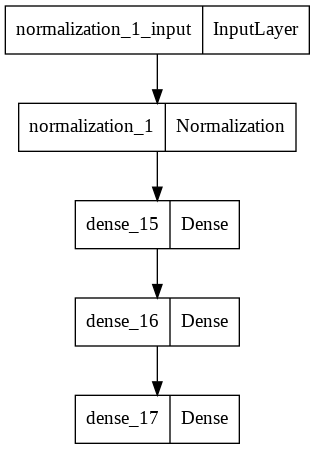

In [ ]:
tf.keras.utils.plot_model(dnn_model)

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=70,
    callbacks =[early_stopping,cp_callback])

Epoch 1/70
43012/43022 [============================>.] - ETA: 0s - loss: 5.0034
Epoch 1: val_loss improved from inf to 3.79456, saving model to /content/drive/MyDrive/AI/AI_Project/Saved_Models
43022/43022 [==============================] - 123s 3ms/step - loss: 5.0031 - val_loss: 3.7946
Epoch 2/70
43008/43022 [============================>.] - ETA: 0s - loss: 3.7730
Epoch 2: val_loss improved from 3.79456 to 3.75368, saving model to /content/drive/MyDrive/AI/AI_Project/Saved_Models
43022/43022 [==============================] - 117s 3ms/step - loss: 3.7731 - val_loss: 3.7537
Epoch 3/70
43012/43022 [============================>.] - ETA: 0s - loss: 3.7354
Epoch 3: val_loss improved from 3.75368 to 3.71858, saving model to /content/drive/MyDrive/AI/AI_Project/Saved_Models
43022/43022 [==============================] - 122s 3ms/step - loss: 3.7354 - val_loss: 3.7186
Epoch 4/70
43021/43022 [============================>.] - ETA: 0s - loss: 3.6904
Epoch 4: val_loss improved from 3.71858 t

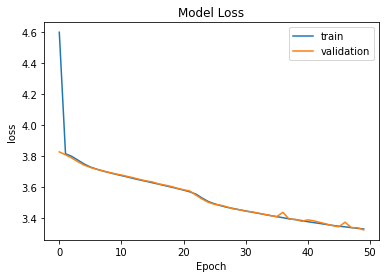

In [ ]:
## Plot train and validation accuracy for each epoch

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([3, 4]) ## Range of y-axis values
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()

In [ ]:
dnn_model.save("./approach2_50.h5")